In [11]:
import importlib
importlib.reload(rp)
importlib.reload(zc)

<module 'rad_pipeline.zipcodes' from '/Users/alexhasha/repos/massenergize/rad_pipeline/rad_pipeline/zipcodes.py'>

In [17]:
from prefect import task, Flow
import rad_pipeline.zipcodes as zc
import rad_pipeline.rad_pipeline as rp
import great_expectations as ge

In [12]:
load_ashp = task(rp.load_ashp)
data_clean = task(rp.data_clean)
data_checkpoint = task(rp.data_checkpoint)


with Flow("RAD pipeline: ASHP") as flow:
    ashp = load_ashp()
    ashp_cleaned = data_clean(ashp, "Air-source Heat Pumps")
    ashp_cleaned = data_checkpoint(
        ashp_cleaned,
        "Air-source Heat Pumps"
    )

In [3]:
flow_state = flow.run()

[2021-03-14 11:18:22-0400] INFO - prefect.FlowRunner | Beginning Flow run for 'RAD pipeline: ASHP'
[2021-03-14 11:18:22-0400] INFO - prefect.TaskRunner | Task 'load_ashp': Starting task run...
[2021-03-14 11:18:26-0400] INFO - prefect.TaskRunner | Task 'load_ashp': Finished task run for task with final state: 'Success'
[2021-03-14 11:18:26-0400] INFO - prefect.TaskRunner | Task 'data_clean': Starting task run...
[2021-03-14 11:20:12-0400] INFO - prefect.TaskRunner | Task 'data_clean': Finished task run for task with final state: 'Success'
[2021-03-14 11:20:12-0400] INFO - prefect.TaskRunner | Task 'data_checkpoint': Starting task run...
[2021-03-14 11:20:13-0400] INFO - prefect.TaskRunner | Task 'data_checkpoint': Finished task run for task with final state: 'Success'
[2021-03-14 11:20:13-0400] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


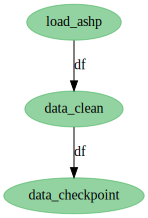

In [4]:
flow.visualize(flow_state=flow_state)

# GHSP

In [7]:
load_gshp = task(rp.load_gshp)

In [13]:
with Flow("RAD pipeline: GSHP") as flow:
    gshp = load_gshp()
    gshp_cleaned = data_clean(gshp, "Ground-source Heat Pumps")
    gshp_cleaned = data_checkpoint(
        gshp_cleaned,
        "Ground-source Heat Pumps"
        )


[2021-03-14 11:54:25-0400] INFO - prefect.FlowRunner | Beginning Flow run for 'RAD pipeline: GSHP'
[2021-03-14 11:54:25-0400] INFO - prefect.TaskRunner | Task 'load_gshp': Starting task run...
[2021-03-14 11:54:26-0400] INFO - prefect.TaskRunner | Task 'load_gshp': Finished task run for task with final state: 'Success'
[2021-03-14 11:54:26-0400] INFO - prefect.TaskRunner | Task 'data_clean': Starting task run...
[2021-03-14 11:54:45-0400] INFO - prefect.TaskRunner | Task 'data_clean': Finished task run for task with final state: 'Success'
[2021-03-14 11:54:45-0400] INFO - prefect.TaskRunner | Task 'data_checkpoint': Starting task run...
[2021-03-14 11:54:45-0400] INFO - prefect.TaskRunner | Task 'data_checkpoint': Finished task run for task with final state: 'Success'
[2021-03-14 11:54:45-0400] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


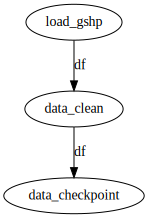

In [14]:
flow_state = flow.run()

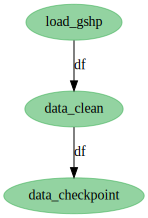

In [16]:
flow.visualize(flow_state=flow_state)

In [19]:
ge.from_pandas(gshp_cleaned.result).validate("../data/expectations/gshp_clean_expectations.json")

{
  "meta": {
    "great_expectations_version": "0.13.12",
    "expectation_suite_name": "default",
    "run_id": {
      "run_name": null,
      "run_time": "2021-03-14T15:57:04.377817+00:00"
    },
    "batch_kwargs": {
      "ge_batch_id": "ebc935f2-84dd-11eb-a4b9-8863dfba332b"
    },
    "batch_markers": {},
    "batch_parameters": {},
    "validation_time": "20210314T155704.370496Z"
  },
  "evaluation_parameters": {},
  "success": false,
  "results": [
    {
      "exception_info": {
        "raised_exception": true,
        "exception_message": "KeyError: 'town_valid'",
        "exception_traceback": "Traceback (most recent call last):\n  File \"/Users/alexhasha/miniconda3/envs/rad_pipeline_env/lib/python3.8/site-packages/pandas/core/indexes/base.py\", line 3080, in get_loc\n    return self._engine.get_loc(casted_key)\n  File \"pandas/_libs/index.pyx\", line 70, in pandas._libs.index.IndexEngine.get_loc\n  File \"pandas/_libs/index.pyx\", line 101, in pandas._libs.index.IndexEngi